# Part 1 test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce RTX 3060 Ti


## Load data

In [2]:
# From pytorch dataset
kmnist_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1918,), (0.3483))]) ### 0.1918 and 0.3483 is the mean and standard deviation of the dataset in tensor format

train_dataset = datasets.KMNIST(root='./data', train=True, transform=kmnist_transform, download=True)
test_dataset = datasets.KMNIST(root='./data', train=False, transform=kmnist_transform, download=True) ### Set download to False if you have dataset


In [3]:
# Create the dataloader 
batch_size = 100 ### Same as the project 1
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          num_workers=2)

test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)


torch.Size([100, 1, 28, 28])


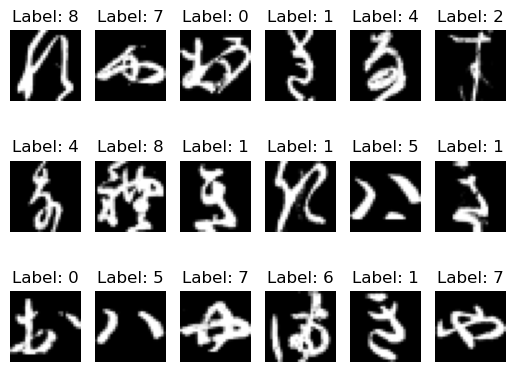

In [4]:
# Visualization of dataset
batch_idx, (data, target) = next(enumerate(train_loader, 0))
print(data.shape)

fig = plt.figure()
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.imshow(data[i][0], cmap='gray')
    plt.title('Label: {}'.format(target[i]))
    plt.axis(False)

### Add noise

In [5]:
def add_impulsive_noise(img, noise_prob=0.1):
    """
    Adding impulsive noise (salt and pepper) to the image.
    Args:
    - img (Tensor): A torch tensor representing the image.
    - noise_prob (float): Probability of adding noise to a pixel.
    Returns:
    - Tensor: Noisy image.
    """
    noise = torch.rand(img.size())
    img_noisy = img.clone()
    img_noisy[noise < noise_prob / 2] = 0  # salt noise
    img_noisy[noise > 1 - noise_prob / 2] = 1  # pepper noise
    return img_noisy

from torchvision.datasets import KMNIST

class NoisyKMNIST(KMNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, noise_prob=0.1):
        super(NoisyKMNIST, self).__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.noise_prob = noise_prob

    def __getitem__(self, index):
        img, target = super(NoisyKMNIST, self).__getitem__(index)

        # Convert image to tenso
        if not isinstance(img, torch.Tensor):
            img = transforms.ToTensor()(img)

        # Create noisy image
        noisy_img = add_impulsive_noise(img, self.noise_prob)

        return noisy_img, target

In [7]:
# Define transforms for the original images (without noise addition)
original_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.1918,), (0.3483))])

# Create instances of the NoisyKMNIST dataset
noisy_train_dataset = NoisyKMNIST(root='./data', train=True, transform=original_transform, download=True, noise_prob=0.1)
noisy_test_dataset = NoisyKMNIST(root='./data', train=False, transform=original_transform, download=True, noise_prob=0.1)

In [8]:
noisy_train_loader = DataLoader(noisy_train_dataset, batch_size=batch_size, num_workers=0)
noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=batch_size, num_workers=0, shuffle=True)

Noisy data shape: torch.Size([100, 1, 28, 28])


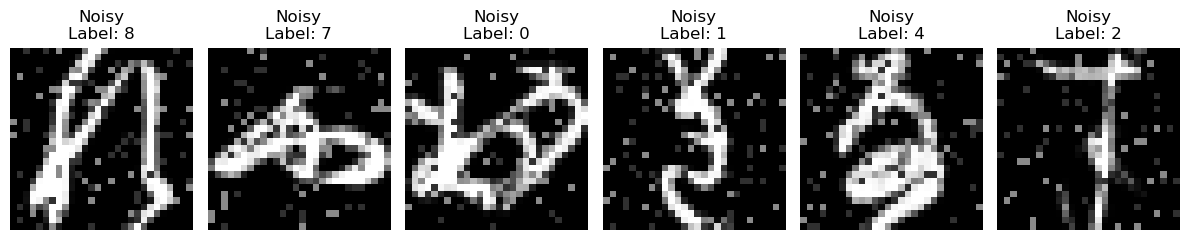

In [9]:
# Visualization of dataset
batch_idx, (noisy_data, target) = next(enumerate(noisy_train_loader, 0))
print("Noisy data shape:", noisy_data.shape)
# print("Clean data shape:", clean_data.shape)

fig = plt.figure(figsize=(12, 8))

for i in range(6):
    # Display noisy images
    plt.subplot(3, 6, i+1)
    plt.imshow(noisy_data[i][0], cmap='gray')
    plt.title('Noisy\nLabel: {}'.format(target[i]))
    plt.axis('off')

    # # Display clean images
    # plt.subplot(3, 6, i+7)
    # plt.imshow(clean_data[i][0], cmap='gray')
    # plt.title('Clean\nLabel: {}'.format(target[i]))
    # plt.axis('off')

plt.tight_layout()

## Load model

In [28]:
# Encoder
class Encoder(nn.Module):
    
    def __init__(self, bottleneck_size):
        '''
        bottleneck_size: dimension of features we encode
        '''
        super(Encoder, self).__init__()
        self.encode_dim = bottleneck_size
        # Hidden layer
        self.fc1 = nn.Linear(784, 800) ### 28 x 28 = 784
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, bottleneck_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
# Decoder
class Decoder(nn.Module):
    
    def __init__(self, bottleneck_size):
        '''
        bottleneck_size: dimension of features we encode
        '''
        super(Decoder, self).__init__()
        self.encode_dim = bottleneck_size
        # Hidden layer
        self.fc1 = nn.Linear(bottleneck_size, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 800)
        self.bn2 = nn.BatchNorm1d(800)
        self.fc3 = nn.Linear(800, 784)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return x
    
# MLP for classification
class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(60, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
class CombinedClassifier(nn.Module):
    def __init__(self, encoder, classifier):
        super(CombinedClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [11]:
# Load the original autoencoder
original_encoder = Encoder(60)
original_decoder = Decoder(60)
original_encoder.load_state_dict(torch.load('./models/encoder_weights.pth', map_location=device))
original_decoder.load_state_dict(torch.load('./models/decoder_weights.pth', map_location=device))

<All keys matched successfully>

In [12]:
# Load the denoise autoencoder with MSE loss
denoise_encoder = Encoder(60)
denoise_decoder = Decoder(60)
denoise_encoder.load_state_dict(torch.load('./models/noisy_encoder_weights.pth', map_location=device))
denoise_decoder.load_state_dict(torch.load('./models/noisy_decoder_weights.pth', map_location=device)) 

<All keys matched successfully>

In [13]:
# Load the denoise autoencoder with correntropy loss
denoise_encoder_corr = Encoder(60)
denoise_decoder_corr = Decoder(60)
denoise_encoder_corr.load_state_dict(torch.load('./models/noisy_encoder_corr_weights.pth', map_location=device))
denoise_decoder_corr.load_state_dict(torch.load('./models/noisy_decoder_corr_weights.pth', map_location=device)) 

<All keys matched successfully>

## Reconstruction

In [22]:
def plot_ae_outputs(encoder,decoder,test_dataset=test_dataset,n=5):
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    plt.figure(figsize=(8,5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()

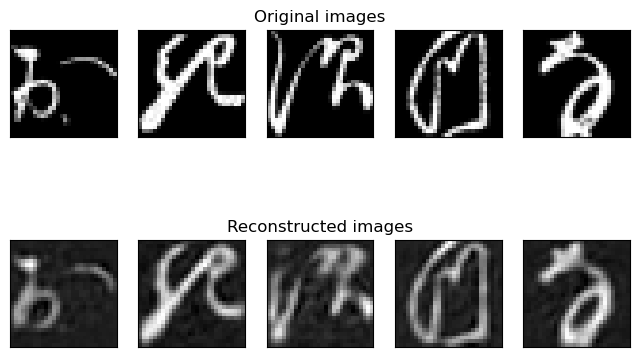

In [21]:
plot_ae_outputs(original_encoder, original_decoder)

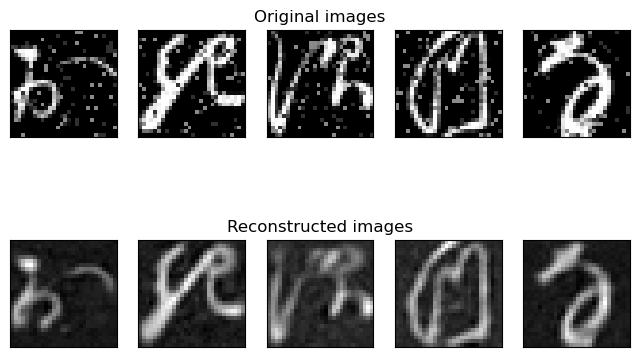

In [23]:
plot_ae_outputs(denoise_encoder, denoise_decoder, test_dataset=noisy_test_dataset)

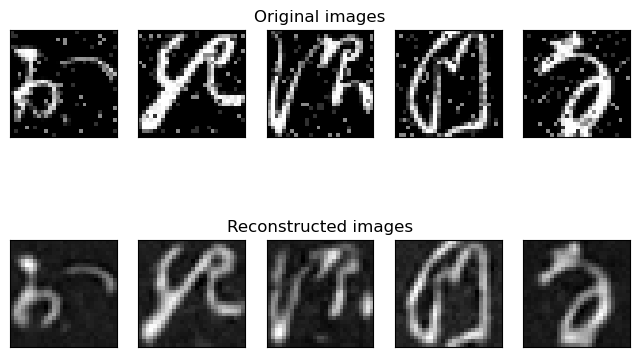

In [24]:
plot_ae_outputs(denoise_encoder_corr, denoise_decoder_corr, test_dataset=noisy_test_dataset)

## Classification

In [29]:
# Load the classifier in project 2
encoder = Encoder(60)
mlp_classsifier = MLPClassifier()
encoder.load_state_dict(torch.load('./models/encoder_weights.pth'))
mlp_classsifier.load_state_dict(torch.load('./models/mlp_classifier_after_encoder_weights_.pth'))

classifier_p2 = CombinedClassifier(encoder, mlp_classsifier)
classifier_p2.load_state_dict(torch.load('./models/sae_mlp_classifier_weights.pth'))

<All keys matched successfully>

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define evaluation function for model
def eval_model(model, test_loader): 
    model = model.to(device)
    model.eval()
    true_labels = []
    predicted_labels = []
    test_probs = []
    
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            _, predicted = torch.max(output.data, 1)
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            
    print('\nACCURACY: {}'.format(accuracy_score(true_labels, predicted_labels)))
    print('----------------------------------')
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(2)), yticklabels=list(range(2)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


ACCURACY: 0.9311
----------------------------------


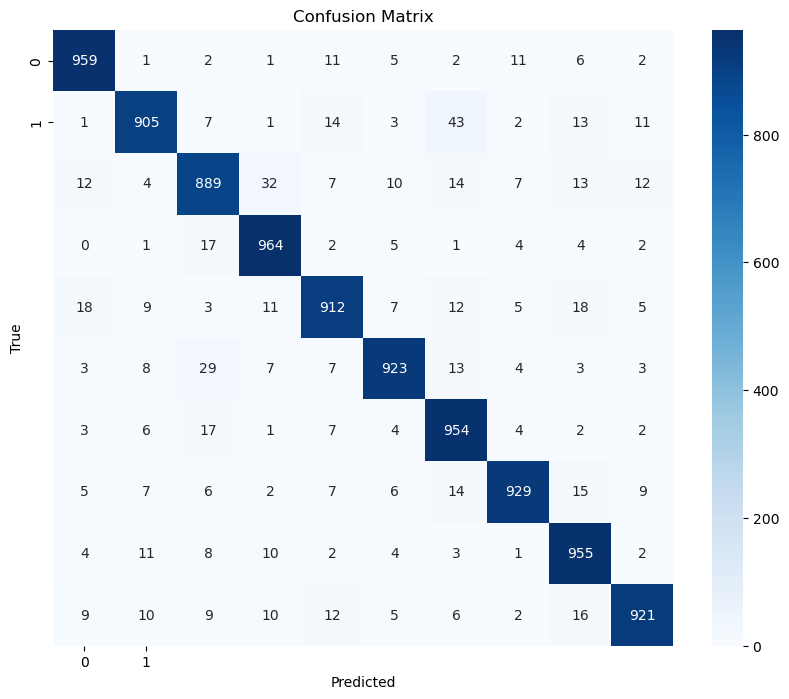

In [31]:
eval_model(classifier_p2, test_loader)

In [32]:
# Structure of encoder(assume bottleneck is 10)
summary(classifier_p2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 800]         628,000
       BatchNorm1d-2                  [-1, 800]           1,600
            Linear-3                  [-1, 200]         160,200
       BatchNorm1d-4                  [-1, 200]             400
            Linear-5                   [-1, 60]          12,060
           Encoder-6                   [-1, 60]               0
            Linear-7                  [-1, 800]          48,800
       BatchNorm1d-8                  [-1, 800]           1,600
            Linear-9                  [-1, 200]         160,200
      BatchNorm1d-10                  [-1, 200]             400
           Linear-11                   [-1, 10]           2,010
    MLPClassifier-12                   [-1, 10]               0
Total params: 1,015,270
Trainable params: 1,015,270
Non-trainable params: 0
---------------------------